# Download SDSS Mosaic Image from SDSS Science Archive Server (SAS)

* Web link: [Imaging Mosaics](https://dr12.sdss.org/mosaics)

![](./data/proj4/1.png)

Fill out the RA and Dec information, and resulting angluar size of the image.
Then click the "Submit" button.

![](./data/proj4/2.png)

Click "Click here to download ~" to get the shell file.

Before you create the mosaic image you have to install `SWarp` package.

If you use Anaconda environment (check your current environment before the installation),
```shell
$ conda install -c conda-forge astromatic-swarp
```

Otherwise you need to install by following [the official website](https://www.astromatic.net/software/swarp/) which I didn't test.


* Useful Resources (If you want to evaluate errors pixel by pixel)
  * [Description of SDSS Imaging Data Files](https://www.sdss4.org/dr16/imaging/images/)
  * [FITS Structure for Corrected Frame](https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/frames/RERUN/RUN/CAMCOL/frame.html)

***

# M51

In this tutorial, we conduct surface photometry of M51, whose image is downloaded
from the archival data of SDSS, to reproduce Figure 21. (see below figure) of [Peng et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010AJ....139.2097P/abstract).

![](./data/proj4/3.png)

Let's make mosaic of M51 field, with the image size of $18'$.
The r-band images of single fields for the mosaics are queried from the above
process, with the RA=202.3984, Dec=47.2252, Image Size=0.5.

We make the mosaic image executing the shell file.

```shell
$ cd <Move To Path Where The Shell File Exists>
$ chmod 744 <Your Shell File>
$ ./<Your Shell File>
```

Here, for example,
```shell
$ cd data/proj4
$ chmod 744 J132947.00+471338.0.sh
$ ./J132947.00+471338.0.sh
```

Then you will get `J132947.00+471338.0-r.fits` and `J132947.00+471338.0-r.weight.fits`,
the r-band image and its weight image.


In [34]:
import os
from pathlib import Path

os.chdir('./data/proj4')
cwd = Path.cwd()
cwd

PosixPath('/Users/hbahk/class/tao23/TAO23/tutorials/data/proj4')

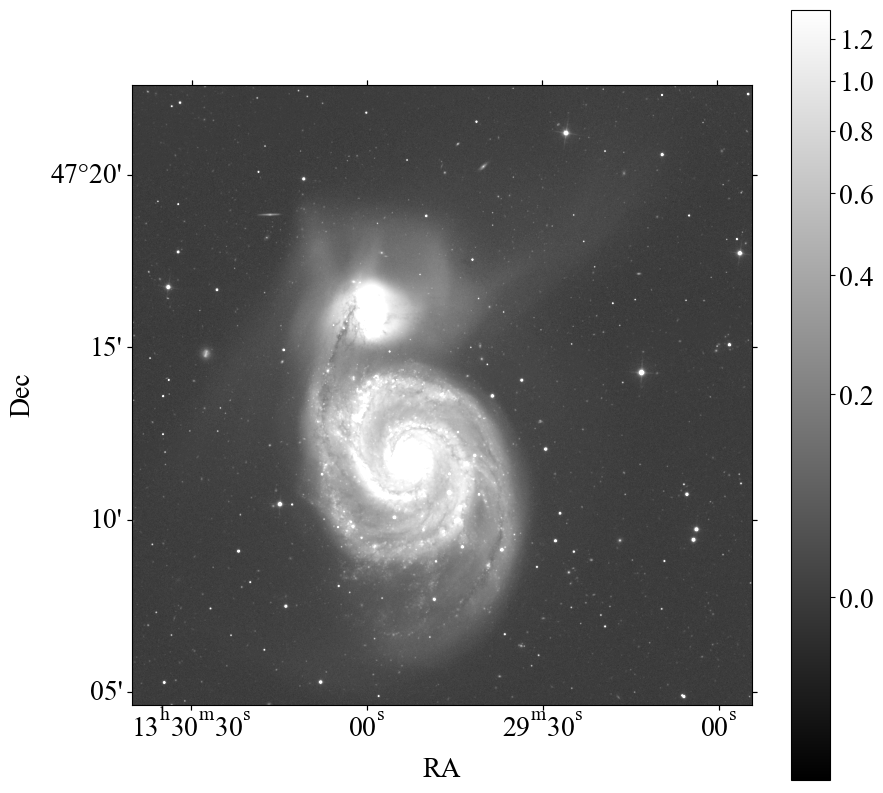

In [35]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import AsymmetricPercentileInterval, AsinhStretch, ImageNormalize
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = ['Times New Roman']
plt.rcParams['font.size'] = 20

name = 'J132947.00+471338.0'

hdu = fits.open(cwd/f'{name}-r.fits')
image = hdu[0].data
wcs = WCS(hdu[0].header)

norm = ImageNormalize(image, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(image, cmap='gray', origin='lower', norm=norm)
fig.colorbar(im)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')


The detector gain of SDSS images differ by the camera column (CAMCOL) and the
bands (u, g, r, i, z). To know the gain of the image, we need to check the
table from the bottom page of this link: [FITS Structure for Corrected Frame](https://data.sdss.org/datamodel/files/BOSS_PHOTOOBJ/frames/RERUN/RUN/CAMCOL/frame.html)
For example, the gain of CAMCOL=1 CCD in r-band is 4.71.
Since the gain is not provided in the header of the corrected frames, `Swarp`
package doesn't provide the average effective gain as usual.

We ignore the effect of gain and the saturation level of the image in this
tutorial, even though they are important in real cases.

Since we need PSF to use GALFIT, we will get PSF of the image using the PSFEx software. If you want more
information about PSFEx, please check this link: [Getting Started](https://psfex.readthedocs.io/en/latest/GettingStarted.html)


In [47]:
# Aperture size for SExtractor run
PHOT_APERTURE = 5 # in arcsec
SCALE = 0.396 # arcsec/pixel
PHOT_APERTURE_PIX = round(PHOT_APERTURE/SCALE)
PHOT_APERTURE_PIX

13

In [48]:
# SExtractor parameter file setting
param_name = "output.param"
f = open(param_name, "w")
f.write("X_IMAGE\n")         # Object position along x [pixel]
f.write("Y_IMAGE\n")         # Object position along y [pixel]
f.write(f"VIGNET({PHOT_APERTURE_PIX},{PHOT_APERTURE_PIX})\n")  # Pixel data around detection [count]
f.write("FLUX_RADIUS\n")     # Half-light radii
f.write("SNR_WIN\n")         # Gaussian-weighted SNR
f.write("FLUX_APER(1)\n")    # Flux vector within fixed circular aperture(s) [count]
f.write("FLUXERR_APER(1)\n") # RMS error vector for aperture flux(es) [count]
f.write("ELONGATION\n")      # A_IMAGE/B_IMAGE
f.write("FLAGS\n")           # Extraction flags
f.close()

In [53]:
# SExtractor run to feed PSFEx
PATH_CONV = '/opt/homebrew/opt/sextractor/share/sextractor/default.conv'
PATH_NNW = '/opt/homebrew/opt/sextractor/share/sextractor/default.nnw'

catalog_name = f'{name}-r.cat'

exec_sextractor = f'sex {name}-r.fits -c default.sex' + \
    f' -CATALOG_NAME {catalog_name}' + \
    f' -PARAMETERS_NAME {param_name}' + \
    f' -FILTER_NAME {PATH_CONV}' + \
    f' -CATALOG_TYPE FITS_LDAC -PHOT_APERTURES {round(PHOT_APERTURE/SCALE)}' 

os.system('sex -d >> default.sex')
os.system(exec_sextractor)


> 
----- SExtractor 2.28.0 started on 2023-05-11 at 19:11:40 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for J132947.00+471338.0-r.fits
----- Measuring from: J132947.00+471338.0-r.fits
      "30 S" / no ext. header / 2727x2727 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at line:  832
> Setting up background map at line:  896
> Setting up background map at line:  960
> Sett

0

In [54]:
# PSFEx run
config_psfex = 'config.psfex'
os.system(f'psfex -d >> {config_psfex}')
os.system(f'psfex {catalog_name} -c {config_psfex}')


> WARNING: This executable has been compiled using a version of the ATLAS library without support for multithreading. Performance will be degraded.

> 
----- PSFEx 3.24.2 started on 2023-05-11 at 19:12:20 with 8 threads

> 
----- 1 input catalogues:
J132947.00+471338.0-:  "30 S            "    1 extension    2273 detections

> Initializing contexts...
> Computing optimum PSF sampling steps...
> Reading data from J132947.00+471338.0-r...
> Computing final PSF model for J132947.00+471338.0-r...
   filename      [ext] accepted/total samp. chi2/dof FWHM ellip. resi. asym.
> Computing diagnostics for J132947.00+471338.0-r...
J132947.00+471338           98/130     0.83   1.09   3.21  0.01  0.02  0.04
> Saving CHECK-image #1...
> Saving CHECK-image #2...
> Saving CHECK-image #3...
> Saving CHECK-image #4...
> Saving CHECK-image #5...
> Saving PSF model and metadata for J132947.00+471338.0-r...
> Writing XML file...
> 
> All done (in 0.0 s)


0

We obtained `J132947.00+471338.0-r.psf`!

In [56]:
phdu = fits.open(f'{name}-r.psf')
phdu.info()

Filename: J132947.00+471338.0-r.psf
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PSF_DATA      1 BinTableHDU     32   1R x 1C   [3750E]   


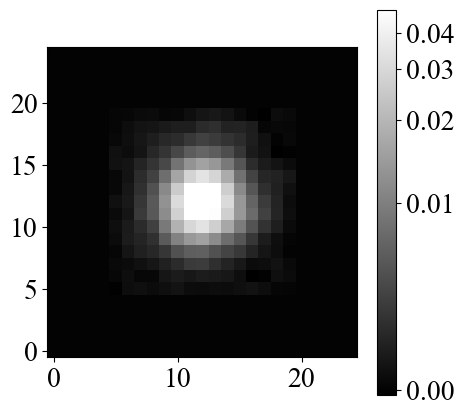

In [71]:
# Inspect the PSF image (at the center of the image)
image_psf = phdu[1].data['PSF_MASK'][0][0]
norm_psf = ImageNormalize(image_psf, interval=AsymmetricPercentileInterval(0., 99.0), stretch=AsinhStretch())

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
pim = ax.imshow(image_psf, cmap='gray', origin='lower', norm=norm_psf)
fig.colorbar(pim)

# Save the PSF image
hdu_psf = fits.PrimaryHDU(image_psf)
hdu_psf.writeto(f'psf_{name}-r.fits', overwrite=True)

In [ ]:
dir_output = 'output'
if not (cwd/dir_output).exists():
    (cwd/dir_output).mkdir()

f = open(f"{name}.feedme", "w")

# Image and GALFIT control parameters (Section 8.1)
f.write(f"A) Input_{name}-r.fits\n")                                            # Input data image
f.write(f"B) {dir_output}/block_{name}.fits\n")                                 # Output data image block
f.write("C) none\n")                                                            # Sigma image name
f.write(f"D) psf_{name}-r.fits\n")                                              # Input PSF image
f.write("E) 1\n")                                                               # PSF find sampling factor relative to data
f.write("F) none\n")#+mask_prefix+f"_{galaxy_id:05d}.fits\n")                   # Bad pixel mask
f.write("G) none\n")                                                            # File with parameter constraints
f.write(f"H) {1:d} {len(image):d} {1:d} {len(image):d}\n")                      # Image region to fit (xmin xmax ymin ymax)
f.write(f"I) 300 300")                                                          # Size of the convolution box (x y)
f.write("J) 22.5")                                                              # Magnitude photometric zeropoint
f.write(f"K) {SCALE:.3f} {SCALE:.3f}\n")                                        # Plate scale (dx dy) [arcsec per pixel]
f.write("O) regular\n")                                                         # Display type (regular, curses, both)
f.write("P) 0\n\n")                                                             # Options (0 = normal run; 1,2 = make model/imgblock & quit)

# Initial fitting parameters
#
#   For object type, the allowed functions are: 
#       nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat, 
#       ferrer, powsersic, sky, and isophote. 
#  
#   Hidden parameters will only appear when they're specified:
#       C0 (diskyness/boxyness), 
#       Fn (n=integer, Azimuthal Fourier Modes),
#       R0-R10 (PA rotation, for creating spiral structures).
# ----------------------------------------------------------------------------
#  Classical Object Fitting Parameters 0-10, and Z (Section 8.2)
# M51A
f.write("0) sersic\n")                                                          # Object type
f.write(f"1) {init.rth:.2f} {init.rth:.2f} 1 1\n")                              # Position (x, y)
f.write(f"3) {d_sep.iloc[galaxy_id-1]['mag']:.3f} 1\n")                         # Total magnitude
f.write(f"4) {d_sep.iloc[galaxy_id-1]['flxrad']:.2f} 1\n")                      # R_e
f.write(f"5) {n_sersic:.1f} 1\n")                                               # Sersic exponent
f.write(f"9) {d_sep.iloc[galaxy_id-1]['b']/d_sep.iloc[galaxy_id-1]['a']:.3f} 1\n")  # Axis ratio (b/a)
f.write(f"10) {d_sep.iloc[galaxy_id-1]['theta']-90.0:.2f} 1\n")                 # Position angle (PA)
f.write("Z) 0\n\n")                                                             # Skip this model in output image? (yes=1, no=0)

f.write("0) sky\n")
f.write("1) 0.00 1\n")  # Sky background
f.write("2) 0.00 1\n")  # dsky/dx
f.write("3) 0.00 1\n")  # dsky/dy
f.write("Z) 0 1\n\n")  # Skip this model in output image?

f.close()

os.chdir(dir_input)
os.system(f"galfit {galaxy_id:05d}.feedme")
os.system("mv -v fit.log "+dir_root+"/"+dir_output+f"/Result_{galaxy_id:05d}.log")
os.system("rm -rfv galfit.*")
os.chdir(init.current_dir)